# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import SquareAttack

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Model

In [5]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train

In [7]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 8s 12ms/step - loss: 1.4259 - accuracy: 0.4874 - val_loss: 1.1239 - val_accuracy: 0.6001
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 0.9728 - accuracy: 0.6582 - val_loss: 0.9809 - val_accuracy: 0.6589
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.7757 - accuracy: 0.7286 - val_loss: 0.7933 - val_accuracy: 0.7212
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6349 - accuracy: 0.7769 - val_loss: 0.7264 - val_accuracy: 0.7487
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.4964 - accuracy: 0.8277 - val_loss: 0.7192 - val_accuracy: 0.7522
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3701 - accuracy: 0.8708 - val_loss: 0.7249 - val_accuracy: 0.7690
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2456 - accuracy: 0.9167 - val_loss: 0.8459 - val_accuracy: 0.7614

# Attack

In [8]:
art_model = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), clip_values=(0, 1))

In [9]:
sa = SquareAttack(estimator=art_model, norm=np.inf, max_iter=100)

In [10]:
adv_test = sa.generate(x=x_test[:16])

SquareAttack - restarts:   0%|          | 0/1 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

# Results

In [11]:
safe_preds = np.argmax(art_model.predict(x_test[:16]), axis=1)

In [12]:
safe_preds

array([3, 8, 8, 8, 4, 6, 5, 3, 3, 1, 0, 9, 5, 7, 9, 8])

In [13]:
y_test = np.argmax(y_test[:16], axis=1)

In [14]:
safe_model_scores = {
    'ACC': accuracy_score(y_test, safe_preds),
    'PREC': precision_score(y_test, safe_preds, average='weighted'),
    'REC': recall_score(y_test, safe_preds, average='weighted'),
    'F1': f1_score(y_test, safe_preds, average='weighted')
}

/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
safe_model_scores

{'ACC': 0.75,
 'PREC': 0.8802083333333333,
 'REC': 0.75,
 'F1': 0.7502976190476189}

In [16]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [17]:
adv_model_scores = {
    'ACC': accuracy_score(y_test, adv_preds),
    'PREC': precision_score(y_test, adv_preds, average='weighted'),
    'REC': recall_score(y_test, adv_preds, average='weighted'),
    'F1': f1_score(y_test, adv_preds, average='weighted')
}

/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
adv_model_scores

{'ACC': 0.0, 'PREC': 0.0, 'REC': 0.0, 'F1': 0.0}

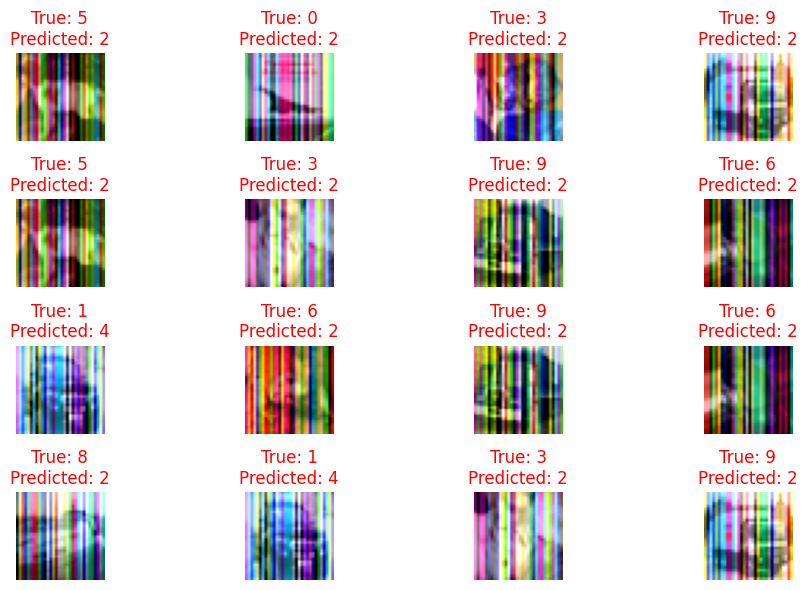

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]], cmap='gray')
    ax.axis('off')

    if y_test[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()